# Introduction

 * Interpolate between electron factors of irregular shapes
 * Interpolation between data many clinics already have
 * To an uncertainty that approaches that of measurement
 * With just eight measurements physicsits can predict to a 0.5% uncertainty

# Overview

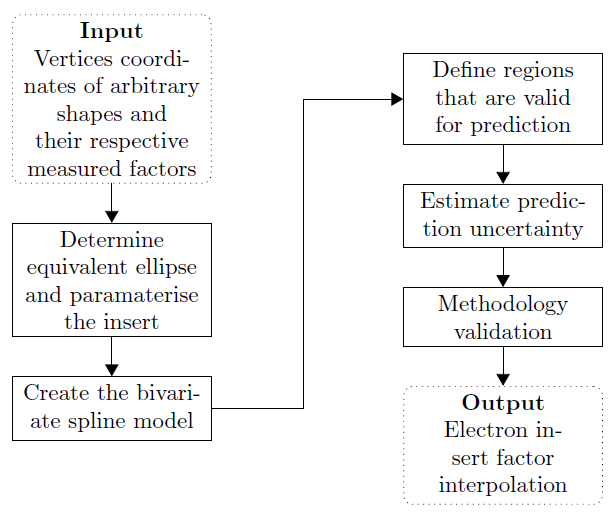

In [20]:
display(Image(filename="flow_diagram.png"))

In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

import shapely.geometry as geo
import descartes as des

from IPython.display import display, HTML, clear_output, Markdown, Image
import ipywidgets as widgets

import sys
sys.path.append("../")

from electronfactors.model.utilities import *
from electronfactors.model.threshold import *
from electronfactors.visuals.utilities import create_green_cm
from electronfactors.visuals.shape_display import display_shapely
from electronfactors.ellipse.utilities import shapely_cutout, shapely_ellipse
green_cm = create_green_cm()

from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})

rc('legend', fontsize=12)

In [2]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.sort([key for key in cutout_data])

# A series of measured inserts

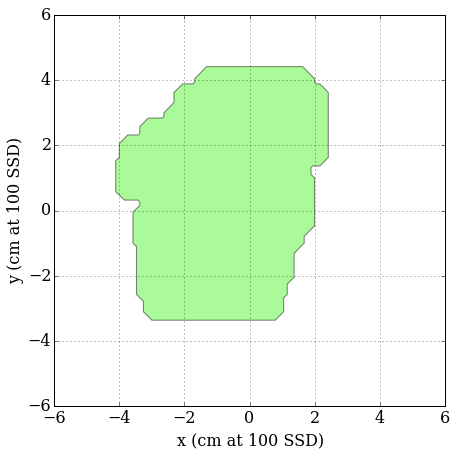

Measured insert factor = 0.9934

In [3]:
select_for_initial_display = widgets.Select(
    options=list(label),
    height='23em',
    width='12em'
)

display(select_for_initial_display)

def initial_display_on_change():
    clear_output(wait=True)
    key = select_for_initial_display.value
    
    cutout = shapely_cutout(
        cutout_data[key]['XCoords'],
        cutout_data[key]['YCoords']
    )
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    patch = des.PolygonPatch(
        cutout,
        fc=np.random.uniform(size=3),
        alpha=0.5)
    ax.add_patch(patch)

    ax.set_xlim([-6,6])
    ax.set_ylim([-6,6])
    ax.set_xlabel('x (cm at 100 SSD)')
    ax.set_ylabel('y (cm at 100 SSD)')
    plt.grid(True)
    plt.show(fig)
    display(Markdown("Measured insert factor = {}".format(cutout_data[key]['factor'])))
    
initial_display_on_change()
select_for_initial_display.on_trait_change(initial_display_on_change, 'value')

# Calculating the width

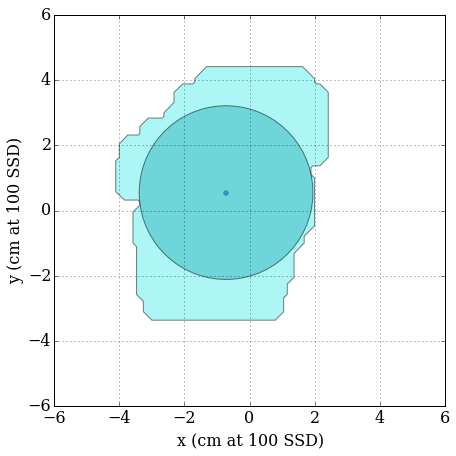

Largest fully encompassed circle has diameter of:
            
 > 5.3 cm at 100 SSD

In [4]:
select_for_show_width = widgets.Select(
    options=list(label),
    height='23em',
    width='12em'
)

display(select_for_show_width)

def show_width_on_change():
    clear_output(wait=True)
    key = select_for_show_width.value
    
    cutout = shapely_cutout(
        cutout_data[key]['XCoords'],
        cutout_data[key]['YCoords']
    )
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    patch = des.PolygonPatch(
        cutout,
        fc=np.random.uniform(size=3),
        alpha=0.5)
    ax.add_patch(patch)
    
    poi = cutout_data[key]['poi']
    plt.scatter(*poi)
    
    width = cutout_data[key]['width']
    circle = geo.Point(*poi).buffer(width/2)
    
    patch = des.PolygonPatch(
        circle,
        fc=np.random.uniform(size=3),
        alpha=0.5)
    ax.add_patch(patch)
    
    ax.set_xlim([-6,6])
    ax.set_ylim([-6,6])
    ax.set_xlabel('x (cm at 100 SSD)')
    ax.set_ylabel('y (cm at 100 SSD)')
    plt.grid(True)
    plt.show(fig)
    display(Markdown(
            """Largest fully encompassed circle has diameter of:
            
 > {0:.1f} cm at 100 SSD""".format(
                cutout_data[key]['width'])))
    
show_width_on_change()
select_for_show_width.on_trait_change(show_width_on_change, 'value')

# Determining the equivalent ellipse

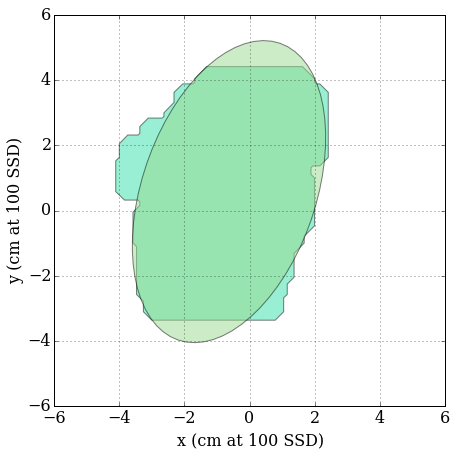

The ellipse with equal area has a length of:
            
 > 9.6 cm at 100 SSD

In [5]:
select_for_show_ellipse = widgets.Select(
    options=list(label),
    height='23em',
    width='12em'
)

display(select_for_show_ellipse)

def show_ellipse_on_change():
    clear_output(wait=True)
    key = select_for_show_ellipse.value
    
    cutout = shapely_cutout(
        cutout_data[key]['XCoords'],
        cutout_data[key]['YCoords']
    )
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    patch = des.PolygonPatch(
        cutout,
        fc=np.random.uniform(size=3),
        alpha=0.5)
    ax.add_patch(patch)
    
    mid = cutout_data[key]['mid']
    angle = cutout_data[key]['angle']
    
    width = cutout_data[key]['width']
    length = cutout_data[key]['length']
    ellipse = shapely_ellipse([
            mid[0], mid[1],
            width, length,
            angle
        ])
    
    patch = des.PolygonPatch(
        ellipse,
        fc=np.random.uniform(size=3),
        alpha=0.5)
    ax.add_patch(patch)
    
    ax.set_xlim([-6,6])
    ax.set_ylim([-6,6])
    ax.set_xlabel('x (cm at 100 SSD)')
    ax.set_ylabel('y (cm at 100 SSD)')
    plt.grid(True)
    plt.show(fig)
    display(Markdown(
            """The ellipse with equal area has a length of:
            
 > {0:.1f} cm at 100 SSD""".format(length)))
    
show_ellipse_on_change()
select_for_show_ellipse.on_trait_change(show_ellipse_on_change, 'value')

# Producing the spline

In [6]:
def display_spline(width, length, factor):
    perimeter = (
        np.pi / 2 * 
        (3*(width + length) - 
         np.sqrt((3*width + length)*(3*length + width))))
    area = np.pi / 4 * width * length
    eqPonA = perimeter / area
    
    model = create_model(width, eqPonA, factor)
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7, 2*(7/1.618)))

    fig.subplots_adjust(right=0.80)
    cbar_ax = fig.add_axes([0.85, 0.125, 0.04, 0.775])
    
    x = np.arange(
        np.floor(np.min(width)) - 1,
        np.ceil(np.max(width)), 0.1)
    y = np.arange(
        np.floor(np.min(eqPonA)*10)/10 - 0.2,
        np.ceil(np.max(eqPonA)*10)/10 + 0.1, 0.02)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give_contour = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

    maximum_eqPonA = to_eqPonA(xx, xx)

    mesh_max_area = ((10 * np.sqrt(2) - xx) * xx + (xx/np.sqrt(2))**2)
    mesh_max_length = 4 * mesh_max_area / (np.pi * xx)

    minimum_rqPonA = to_eqPonA(xx, mesh_max_length)

    full_colour = give_contour < 0.5

    full_colour_zz = zz.copy()
    full_colour_zz[~full_colour] = np.nan
    
    vmin = 0.92
    vmax = 1.015

    circle_bound_width = np.linspace(2, 10)
    circle_bound_eqPonA = to_eqPonA(circle_bound_width, circle_bound_width)

    max_eqPonA_width = np.linspace(2, 10)
    max_area = (
        (10 * np.sqrt(2) - max_eqPonA_width) * 
        max_eqPonA_width + (max_eqPonA_width/np.sqrt(2))**2)
    max_length = 4 * max_area / (np.pi * max_eqPonA_width)
    max_eqPonA = to_eqPonA(max_eqPonA_width, max_length)

    ax1.contourf(
        xx, yy, full_colour_zz, 40, alpha=1, 
        cmap=green_cm, vmin=vmin, vmax=vmax)
    ax1.contour(
        xx, yy, full_colour_zz, 40, alpha=1, 
        cmap=green_cm, vmin=vmin, vmax=vmax)

    norm = Normalize(vmin=vmin, vmax=vmax)

    cb = ColorbarBase(
        cbar_ax, cmap=green_cm, alpha=1,
        norm=norm, label=r'Insert factor')

    ax1.scatter(
        width, eqPonA, s=150, lw=2,
        c=factor, cmap=green_cm, 
        vmin=vmin, vmax=vmax,
        zorder=100)

    ax1.scatter(
        [-1]*3, [-1]*3, s=150, lw=2,
        c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
        zorder=100, 
        label='Measured 12 MeV data')

    ax1.contour(xx, yy, give_contour, levels=[0.5], colors='k')
    ax1.plot(3, 0.4, 'k-', label='Deformability boundary')

    ax1.plot(
        circle_bound_width, circle_bound_eqPonA, 
        'k', lw=3, label='Circle bound', zorder=99)
    ax1.plot(
        max_eqPonA_width, max_eqPonA, 'k--', 
        lw=3, label='Approx. applicator bound', zorder=99)

    ax1.set_xlabel('Width (cm)')
    ax1.set_ylabel('Perimeter / Area (cm$^{-1}$)')
    ax1.set_xlim([2.4, 9.8])
    ax1.set_ylim([0.36, 1.4])

    tk_all = ax1.get_xticklabels()
    for tk in tk_all:
        tk.set_visible(True)
        
        
    x = np.arange(2.5, 10, 0.1)
    y = np.arange(2.5, 18, 0.2)

    mesh_width, mesh_length = np.meshgrid(x, y)

    mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

    width_length_zz = model(mesh_width, mesh_eqPonA)
    give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)


    mesh_max_area = (
        (10 * np.sqrt(2) - mesh_width) * 
        mesh_width + (mesh_width/np.sqrt(2))**2)
    mesh_max_length = 4 * mesh_max_area / (np.pi * mesh_width)

    full_colour = give < 0.5

    full_colour_width_length_zz = width_length_zz.copy()
    full_colour_width_length_zz[~full_colour] = np.nan

    circle_bound_width = np.linspace(2, 11)

    max_length_width = np.linspace(2, 11)
    max_area = (
        (10 * np.sqrt(2) - max_length_width) * 
        max_length_width + (max_length_width/np.sqrt(2))**2)
    max_length = 4 * max_area / (np.pi * max_length_width)

    c = ax2.contourf(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)
    ax2.contour(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)

    ax2.scatter(
        width, length, s=150, lw=2,
        c=factor, cmap=green_cm, 
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=2,
        c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
        zorder=3, 
        label='Measured 12 MeV data')

    ax2.contour(mesh_width, mesh_length, give, levels=[0.5], colors='k')
    ax2.plot(3, 0.4, 'k-', label='Deformability boundary')

    ax2.plot(
        circle_bound_width, circle_bound_width, 
        'k', lw=3, label='Circle bound', zorder=2)
    ax2.plot(
        max_length_width, max_length, 
        'k--', lw=3, label='Approx. applicator bound', zorder=2)

    ax2.set_xlabel('Width (cm)')
    ax2.set_ylabel('Length (cm)')
    ax2.set_xlim([2.4, 9.8])
    ax2.set_ylim([2, 14])

    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, ncol=2)

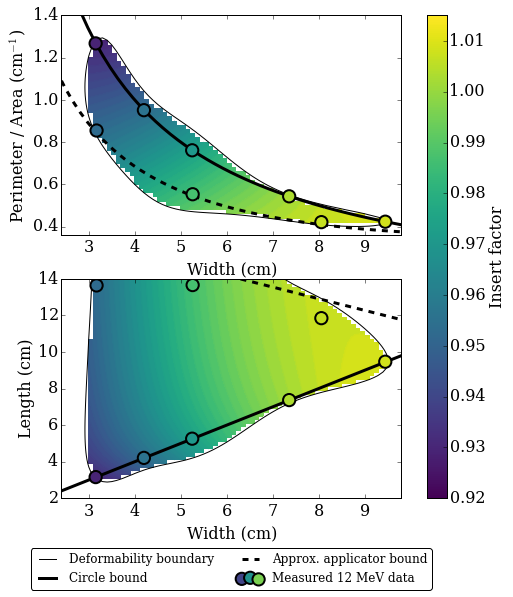

In [7]:
select_for_spline = widgets.SelectMultiple(
    options=list(label),
    height='23em',
    width='12em',
    value=(
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
)

button_calculate_spline = widgets.Button(
    description="Calculate",
    width='13em')

button_default_spline = widgets.Button(
    description="Default",
    width='13em')

display(select_for_spline, button_calculate_spline, button_default_spline)

def on_button_clicked_spline(b):
    clear_output(wait=True)
    
    if len(select_for_spline.value) < 8:
        raise Exception("Need at least 8 data points for spline")
    
    width = np.array([
            cutout_data[key]['width']
            for key in select_for_spline.value
        ])
    length = np.array([
            cutout_data[key]['length']
            for key in select_for_spline.value
        ])
    factor = np.array([
            cutout_data[key]['factor']
            for key in select_for_spline.value
        ])
    
    display_spline(width, length, factor)

def default_button_spline(b):
    select_for_spline.value = (
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
    
    on_button_clicked_spline(0)
    
on_button_clicked_spline(0)
button_calculate_spline.on_click(on_button_clicked_spline)
button_default_spline.on_click(default_button_spline)

# Where to measure for optimum coverage

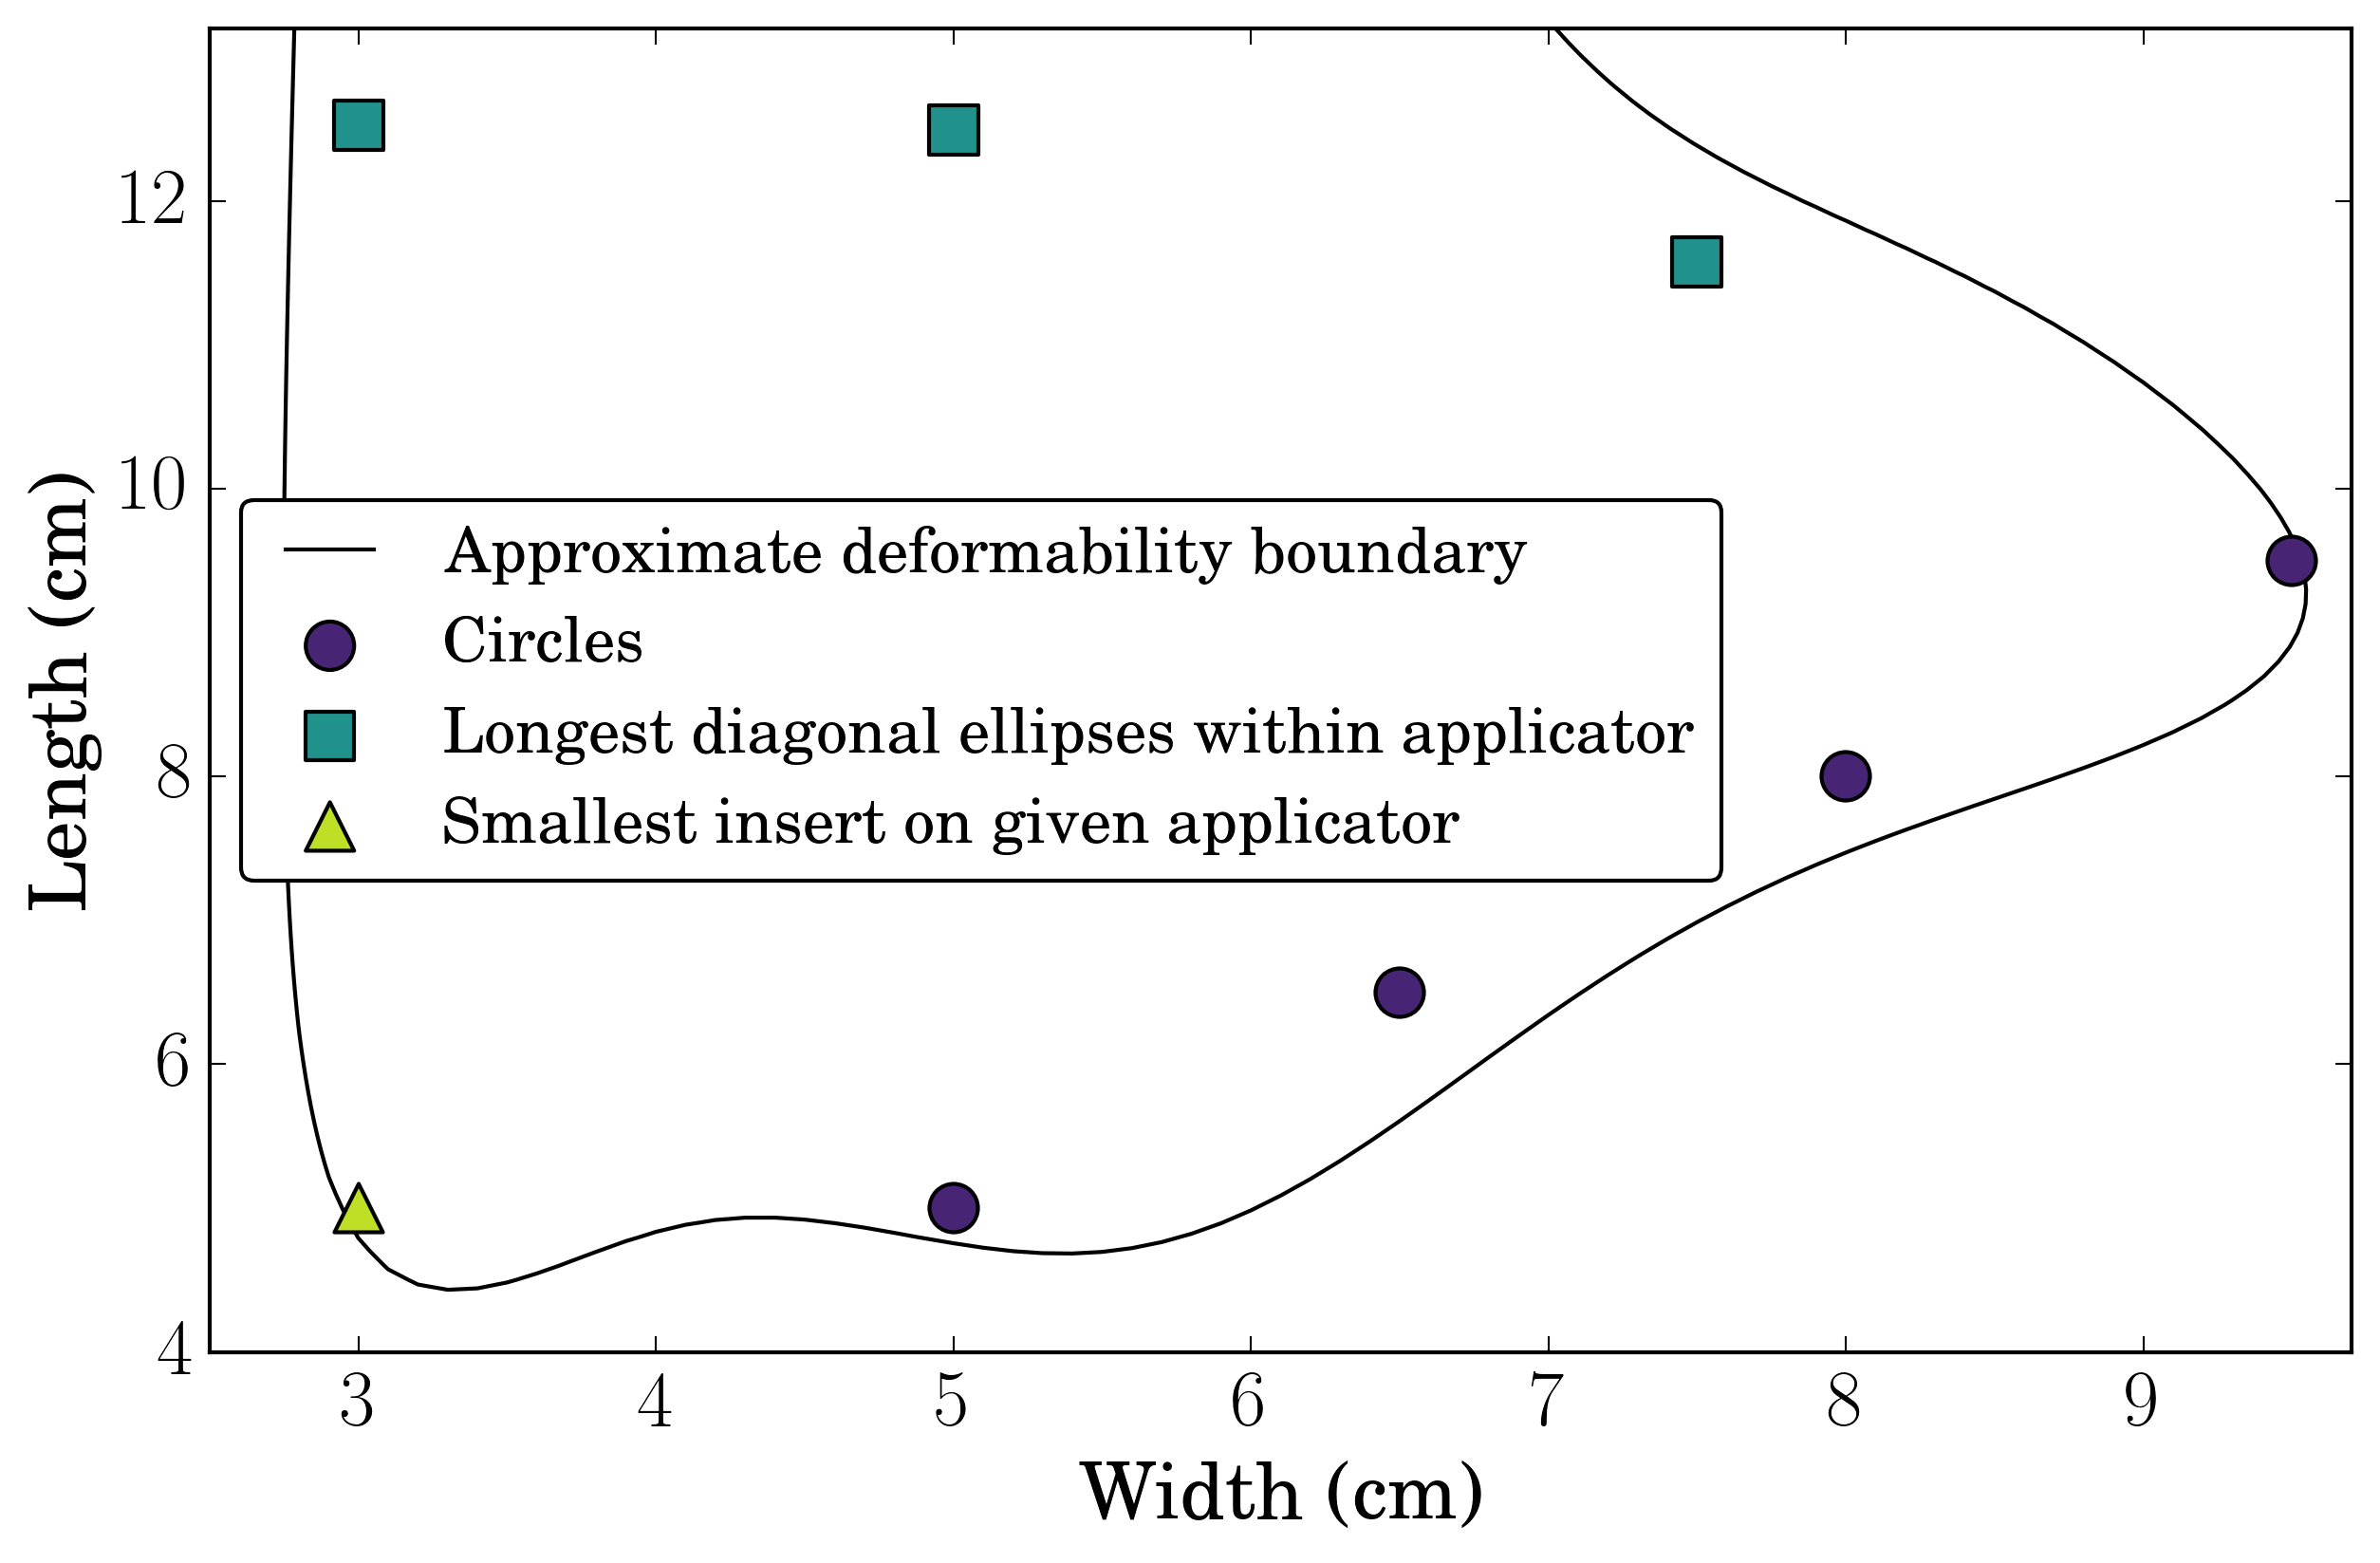

In [8]:
display(Image(filename="where_to_measure.png"))

# Determining valid prediction region

# Display prediction difference

# Example prediction differences

In [9]:
def colour(x, alpha=1):
    result = list(green_cm(x))
    result[3] = alpha
    
    return result

def display_prediction_differences(label_model):
    width = np.array([
            cutout_data[key]['width']
            for key in label_model
        ])
    length = np.array([
            cutout_data[key]['length']
            for key in label_model
        ])
    factor = np.array([
            cutout_data[key]['factor']
            for key in label_model
        ])
    
    perimeter = (
        np.pi / 2 * 
        (3*(width + length) - 
         np.sqrt((3*width + length)*(3*length + width))))
    area = np.pi / 4 * width * length
    eqPonA = perimeter / area
    
    model = create_model(width, eqPonA, factor)
    
    
    label_not_modelled = np.setdiff1d(label, label_model)
    
    width_not_modelled = np.array([
            cutout_data[key]['width']
            for key in label_not_modelled
        ])
    length_not_modelled = np.array([
            cutout_data[key]['length']
            for key in label_not_modelled
        ])
    factor_not_modelled = np.array([
            cutout_data[key]['factor']
            for key in label_not_modelled
        ])
    
    perimeter_not_modelled = (
        np.pi / 2 * 
        (3*(width_not_modelled + length_not_modelled) - 
         np.sqrt((3*width_not_modelled + length_not_modelled)*(3*length_not_modelled + width_not_modelled))))
    area_not_modelled = np.pi / 4 * width_not_modelled * length_not_modelled
    eqPonA_not_modelled = perimeter_not_modelled / area_not_modelled
    
    give_points = fit_give(
        width_not_modelled, eqPonA_not_modelled, width, eqPonA, factor, kx=2, ky=1)
    valid_points = give_points < 0.5
    
    valid_predictions = model(
        width_not_modelled[valid_points], eqPonA_not_modelled[valid_points])
    prediction_differences = 100 * (
        (factor_not_modelled[valid_points] - valid_predictions) / 
        factor_not_modelled[valid_points])

    
    vmin = 0.92
    vmax = 1.015
    
    
    
    fig, ax2 = plt.subplots(1, sharex=True, figsize=(7, (7/1.618)))

    fig.subplots_adjust(right=0.80)
    cbar_ax = fig.add_axes([0.85, 0.125, 0.04, 0.775])        
        
    x = np.arange(2.5, 10, 0.1)
    y = np.arange(2.5, 18, 0.2)

    mesh_width, mesh_length = np.meshgrid(x, y)

    mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

    width_length_zz = model(mesh_width, mesh_eqPonA)
    give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)


    mesh_max_area = (
        (10 * np.sqrt(2) - mesh_width) * 
        mesh_width + (mesh_width/np.sqrt(2))**2)
    mesh_max_length = 4 * mesh_max_area / (np.pi * mesh_width)

    full_colour = give < 0.5

    full_colour_width_length_zz = width_length_zz.copy()
    full_colour_width_length_zz[~full_colour] = np.nan

    circle_bound_width = np.linspace(2, 11)

    max_length_width = np.linspace(2, 11)
    max_area = (
        (10 * np.sqrt(2) - max_length_width) * 
        max_length_width + (max_length_width/np.sqrt(2))**2)
    max_length = 4 * max_area / (np.pi * max_length_width)

    c = ax2.contourf(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)
    ax2.contour(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                     alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)

    ax2.scatter(
        width, length, s=150, lw=2,
        c=factor, cmap=green_cm, 
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=2,
        c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
        zorder=3, 
        label='Data used in model')
    
    
    ax2.scatter(
        width_not_modelled[valid_points], length_not_modelled[valid_points], 
        s=150, lw=2, edgecolor='blue',
        c=factor_not_modelled[valid_points], cmap=green_cm, 
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=2, edgecolor='blue',
        c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
        zorder=3, 
        label='Test data within valid region')
    
    
    ax2.scatter(
        width_not_modelled[~valid_points], length_not_modelled[~valid_points], 
        s=150, lw=2, edgecolor='red',
        c=factor_not_modelled[~valid_points], cmap=green_cm, 
        vmin=vmin, vmax=vmax,
        zorder=3)

    ax2.scatter(
        [-1]*3, [-1]*3, s=150, lw=2, edgecolor='red',
        c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
        zorder=3, 
        label='Test data outside valid region')
    

    ax2.contour(mesh_width, mesh_length, give, levels=[0.5], colors='k')
    ax2.plot(3, 0.4, 'k-')

    ax2.plot(
        circle_bound_width, circle_bound_width, 
        'k', lw=3, zorder=2)
    ax2.plot(
        max_length_width, max_length, 
        'k--', lw=3, zorder=2)

    ax2.set_xlabel('Width (cm)')
    ax2.set_ylabel('Length (cm)')
    ax2.set_xlim([2.4, 9.8])
    ax2.set_ylim([2, 14])

    legend = ax2.legend(fancybox=True, loc='lower right')
    legend.get_frame().set_facecolor([1,1,1,0.5])
    
    norm = Normalize(vmin=vmin, vmax=vmax)

    cb = ColorbarBase(
        cbar_ax, cmap=green_cm, alpha=1,
        norm=norm, label=r'Insert factor')
    
    plt.figure(figsize=(7, (7/1.618)))

    bins = np.arange(-2.0, 2.01, 1/3)
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - prediction_differences),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):
        binRef = (binNum == i)
        representative_height[binRef] = np.arange(sum(binRef)) + 1
    
    plt.hist(
        prediction_differences, bins, 
        fc=colour(0.6), lw=1)
    plt.scatter(
        prediction_differences, 
        representative_height, zorder=2, 
        s=80, lw=1, edgecolor='black', color=colour(0.4))
    
    plt.xlim([-2,2])
    
    plt.xlabel(
        '% Prediction Difference '
        '[100 $\\times$ (meas - pred)/meas]')
    plt.ylabel('Frequency')

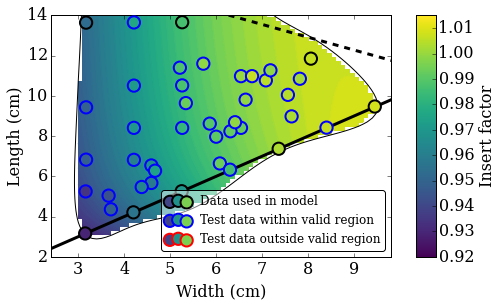

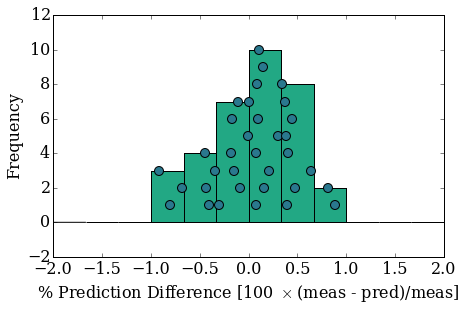

In [10]:
select_for_prediction_diffs = widgets.SelectMultiple(
    options=list(label),
    height='23em',
    width='12em',
    value=(
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
)

button_calculate_prediction_diffs = widgets.Button(
    description="Calculate",
    width='13em')

button_default_prediction_diffs = widgets.Button(
    description="Default",
    width='13em')

display(select_for_prediction_diffs, button_calculate_prediction_diffs, button_default_prediction_diffs)

def on_button_clicked_prediction_diffs(b):
    clear_output(wait=True)
    label_model = select_for_prediction_diffs.value
    
    if len(label_model) < 8:
        raise Exception("Need at least 8 data points for spline")    
    
    display_prediction_differences(label_model)

def default_button_prediction_diffs(b):
    select_for_prediction_diffs.value = (
        'Simon #32 cutout', 
        'Simon 3cm circle',
        'Simon 3x13cm oval',
        'Simon 4cm circle',
        'Simon 5cm circle',
        'Simon 5x13cm oval',
        'Simon 7cm circle',
        'Simon 9cm circle'        
    )
    
    on_button_clicked_prediction_diffs(0)
    
on_button_clicked_prediction_diffs(0)
button_calculate_prediction_diffs.on_click(on_button_clicked_prediction_diffs)
button_default_prediction_diffs.on_click(default_button_prediction_diffs)

# Prediction differences with one point removed at a time

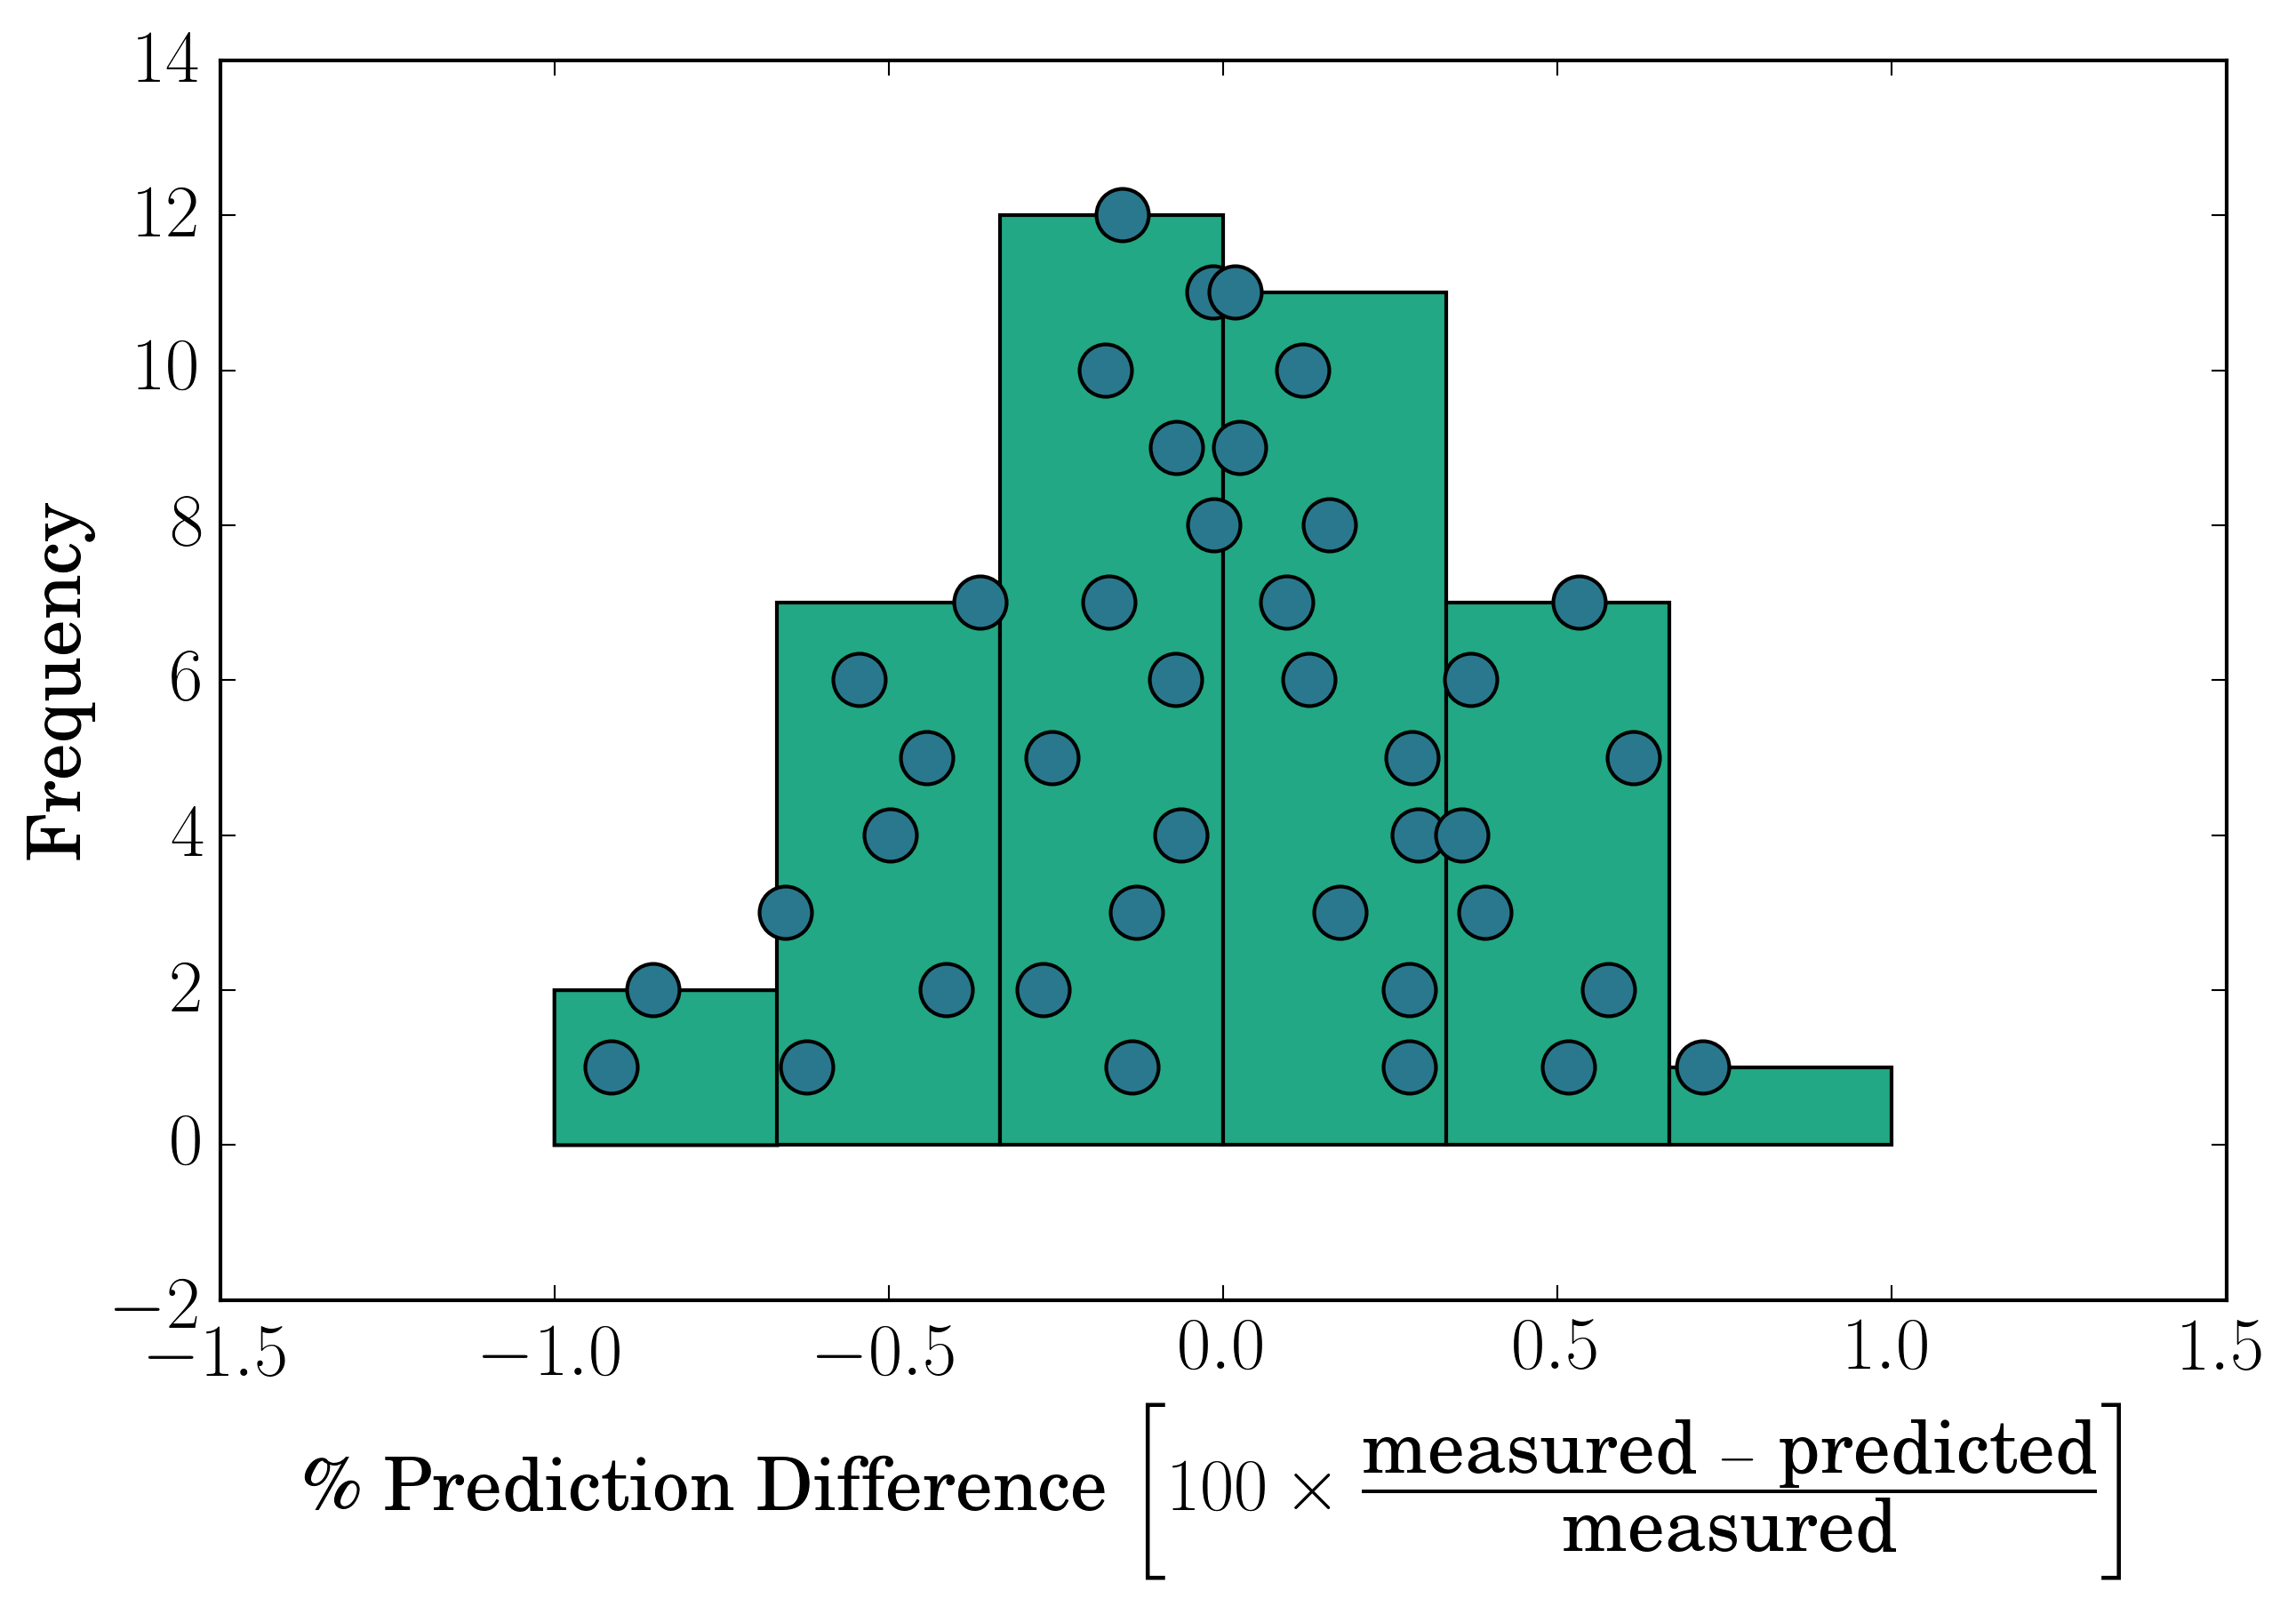

In [17]:
display(Image(filename="prediction_difference_histogram.png"))

# Estimated expected uncertainty

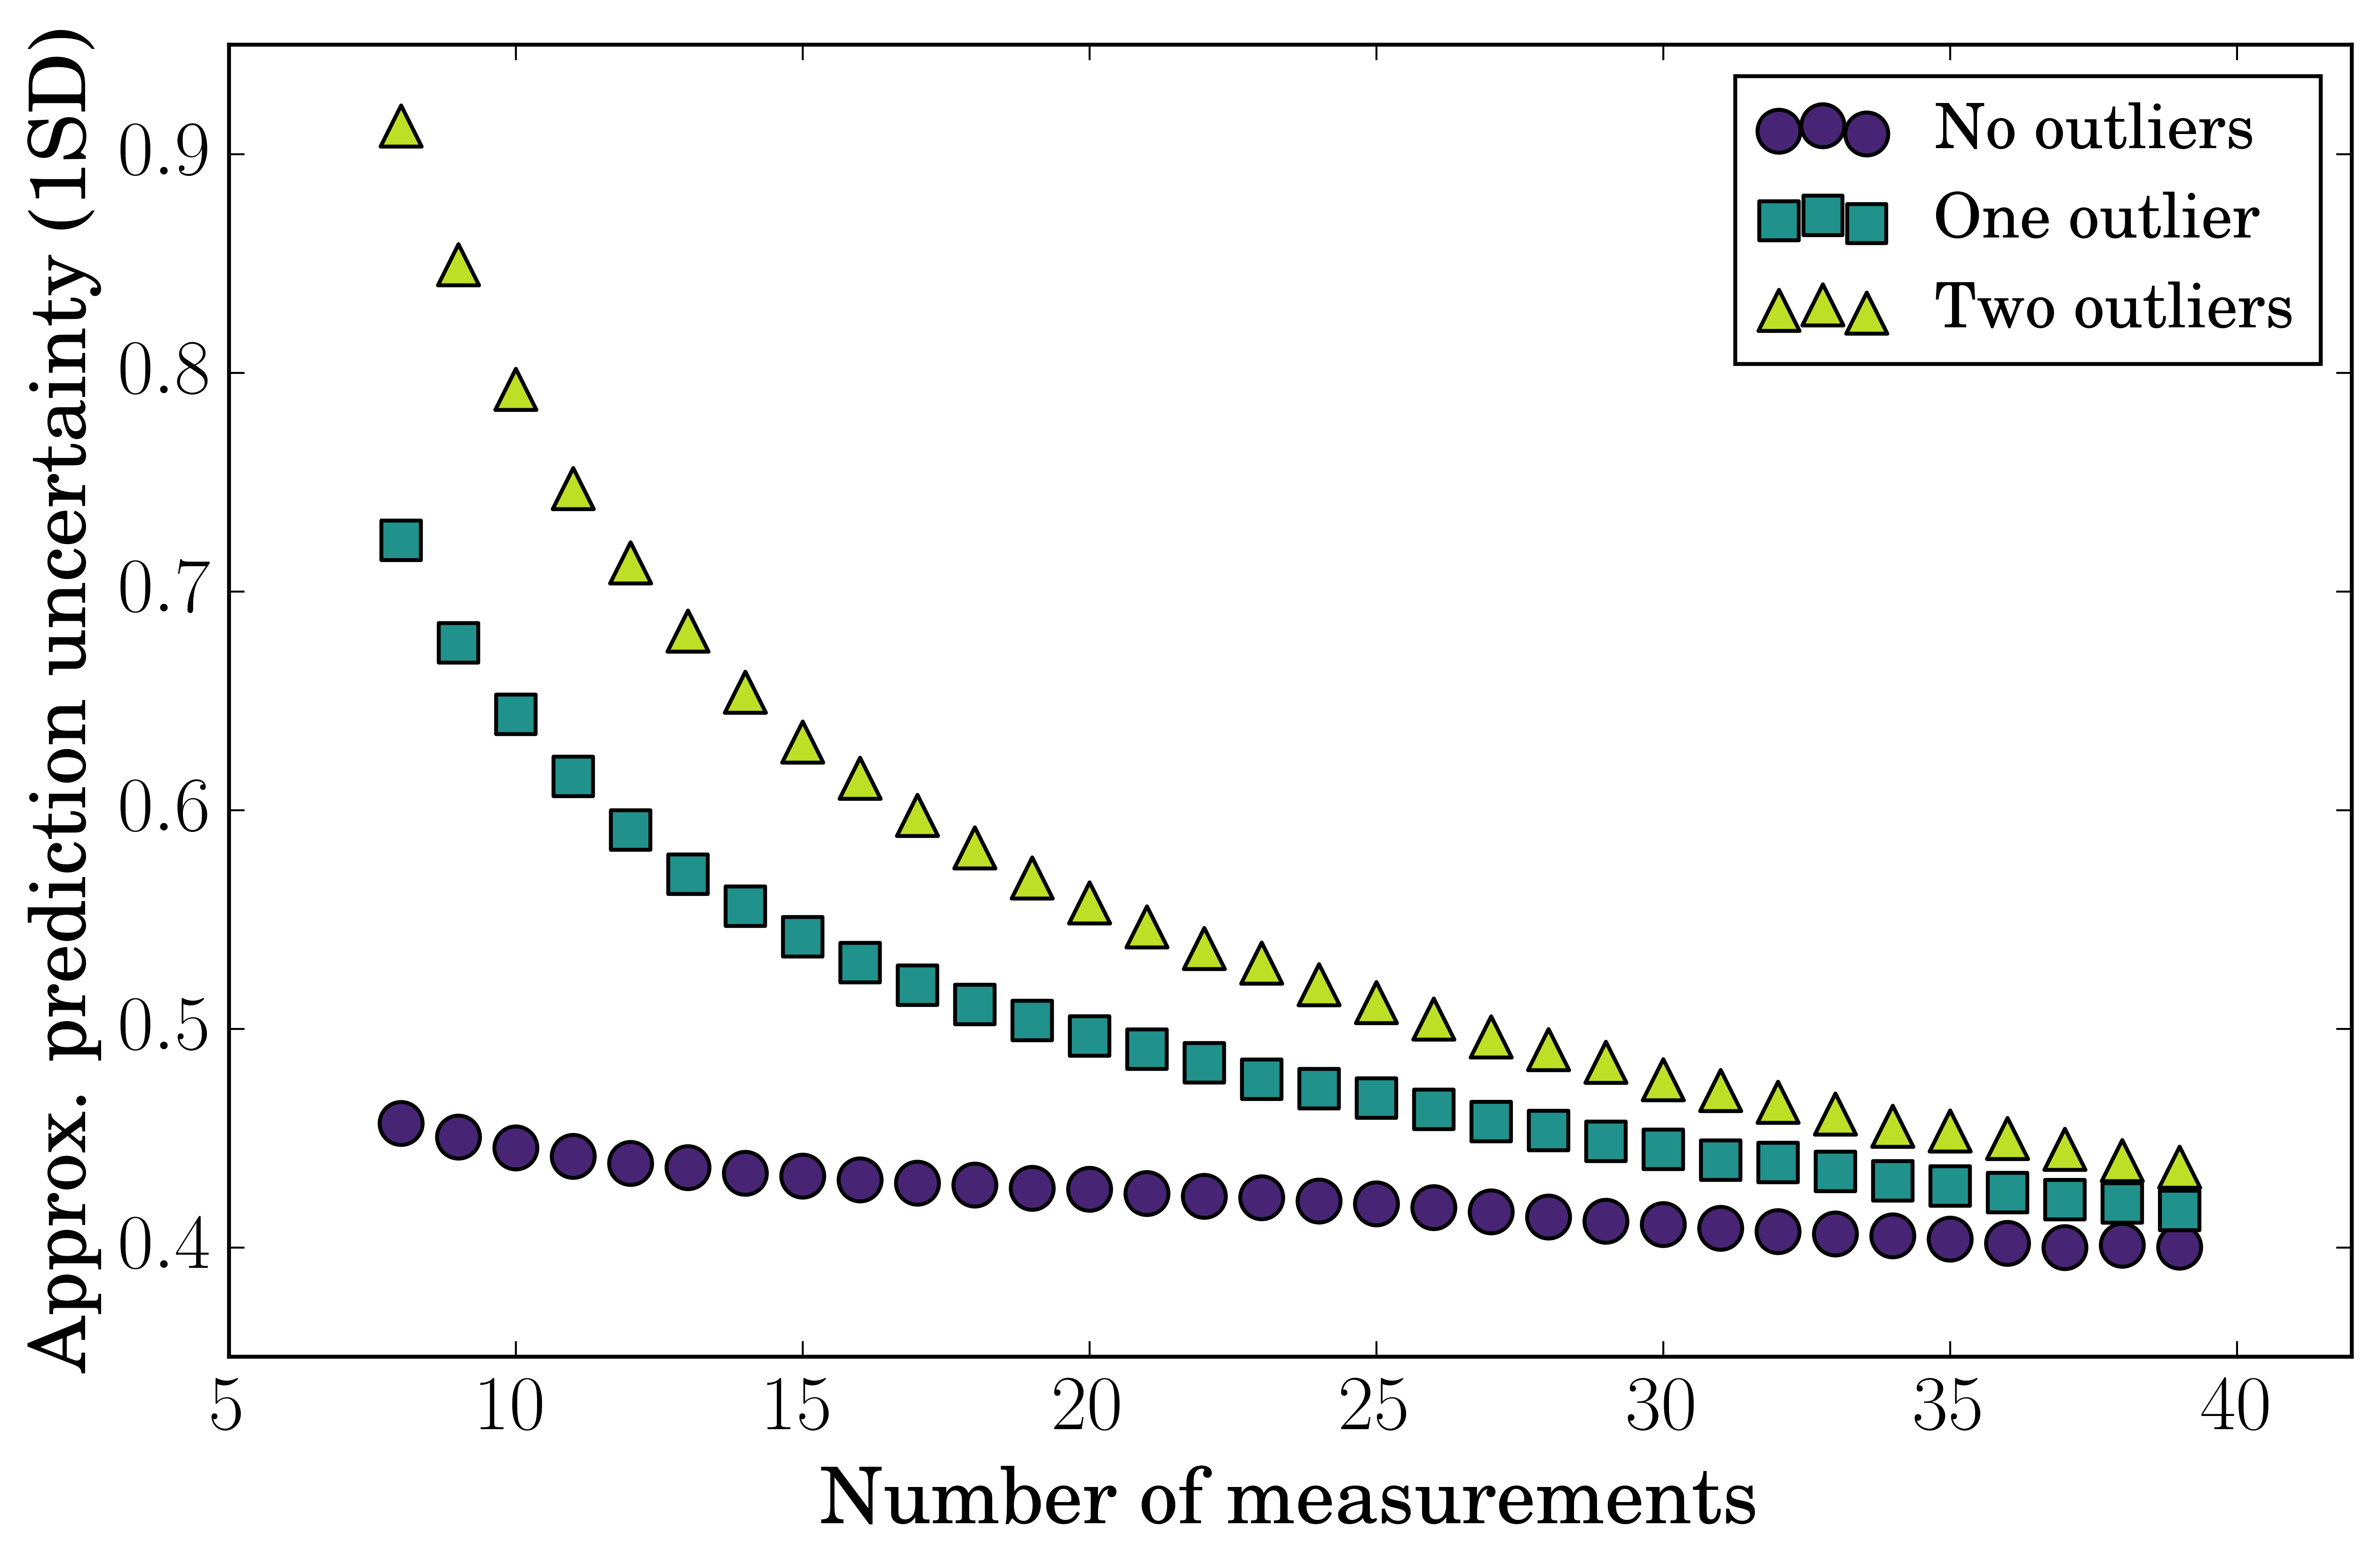

In [18]:
display(Image(filename="change_with_number_measurements.png"))

# Overview of results

 * 12 MeV validation data had a predicition uncertainty of 0.4%
 * For 6, 9, 15, and 18 MeV the maximum recorded deviations were 0.8%, 0.8%, 0.9%, and 1.0%
 * One may expect an approximate uncertainty of 0.5% when as little as 8 data points are used
 * In 10^6 predictions no random subset of 8 datapoints produced a prediction difference greater than 2%

# Conclusion

 * A method that is easy to impliment
 * Uncertainty approaching measurement
 * Builds upon the vast amount of data already available
 * The level of accuracy combined with the ease with which this model can be generated demonstrates its suitability for clinical use

In [15]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'linear',
              'start_slideshow_at': 'beginning',
});


display(HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.cell').css("flex-direction", "row");
 $('div.output').css("min-width", "700px");
 $('div.output').css("max-width", "1000px");
 } else {
 $('div.input').show();
 $('div.cell').css("flex-direction", "column");
 $('div.output').css("min-width", "0");
 }
 code_show = !code_show
} 
$( document 
).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
    <input type="submit" value="Slide setup (on/off)">
</form>'''))